In [1]:
#automatic fitting of geometric parameters in single script.
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import griddata
from scipy.ndimage import interpolation
from matplotlib.colors import hsv_to_rgb
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
folder = 'H:/ptycho/'
dat4d = np.load(folder+'1bin.npy')
pacbed = np.average(dat4d, axis=(0,1))
np.save(folder+'pacbed.npy', pacbed)

Text(0.5, 1.0, 'position averaged CBED')

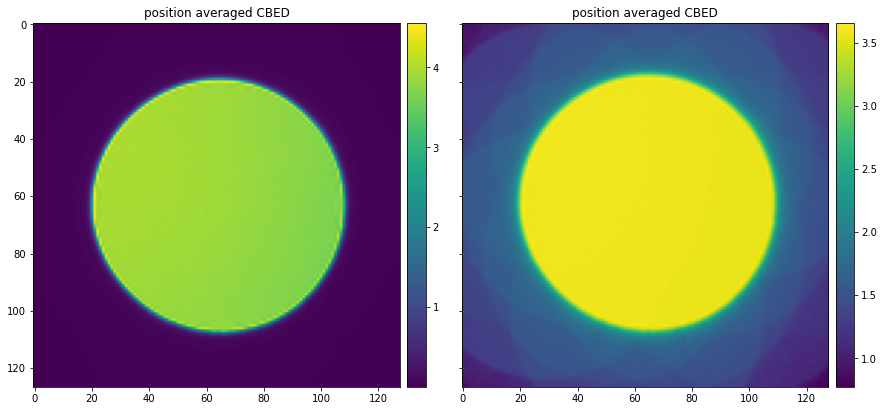

In [3]:
fig =plt.figure(1, figsize=(50, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(np.log10(pacbed*1000+1.0)[1:], cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("position averaged CBED")

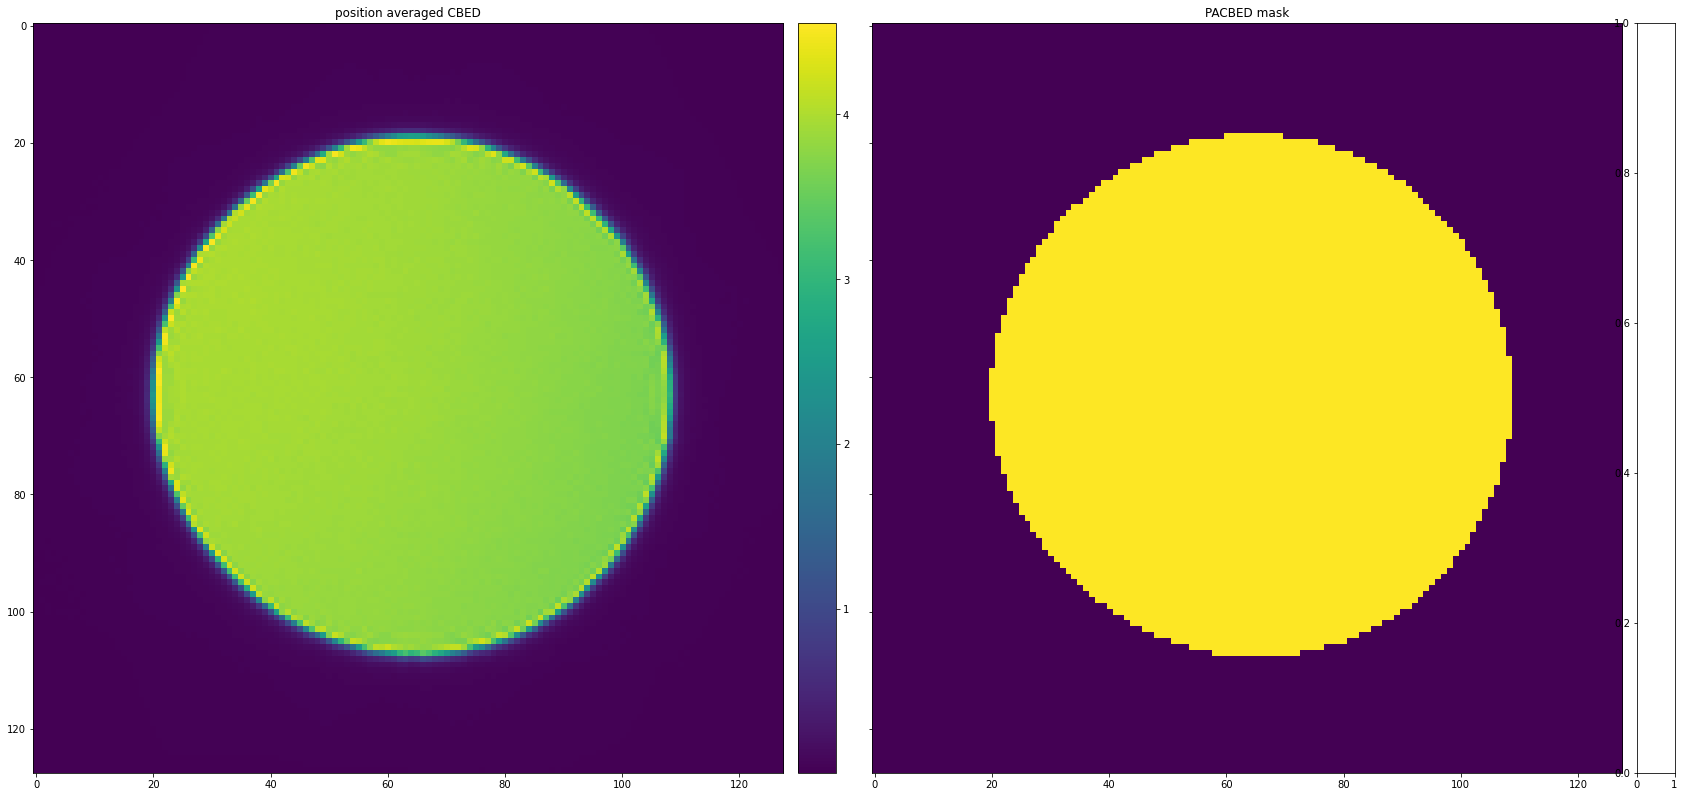

In [47]:
#deal with the bad pixels.
#pacbed[120, 132] = pacbed[120, 131]
#pacbed[161, 87] = pacbed[120, 131]
#pacbed[122, 12] = 0
#compute the center and radius of aperture (the center and radius is not necessarilty too accurate.)
mpacbed = np.zeros_like(pacbed)
mpacbed[np.where(pacbed > np.max(pacbed)*0.35)] = 1.0
Y, X = np.indices(pacbed.shape)
x_center, y_center =np.average(mpacbed * X), np.average(mpacbed * Y)
x_center/=np.average(mpacbed)
y_center/=np.average(mpacbed)
#get the coarse radius of the aperture if treated as a circule.
radius = np.sqrt(np.sum(mpacbed)/np.pi)
#plot the CBED and its graident and the corresponding circle.
fig =plt.figure(1, figsize=(100, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(mpacbed, cmap=plt.cm.viridis)
grid[1].set_title("PACBED mask")
#save the masked PACBED for probe generation.
mpacbed = mpacbed*np.sum(pacbed)/np.sum(mpacbed)
np.save(folder + "probe mask.npy", np.float32(mpacbed))

Text(0.5, 1.0, 'Annular Dark Field Image')

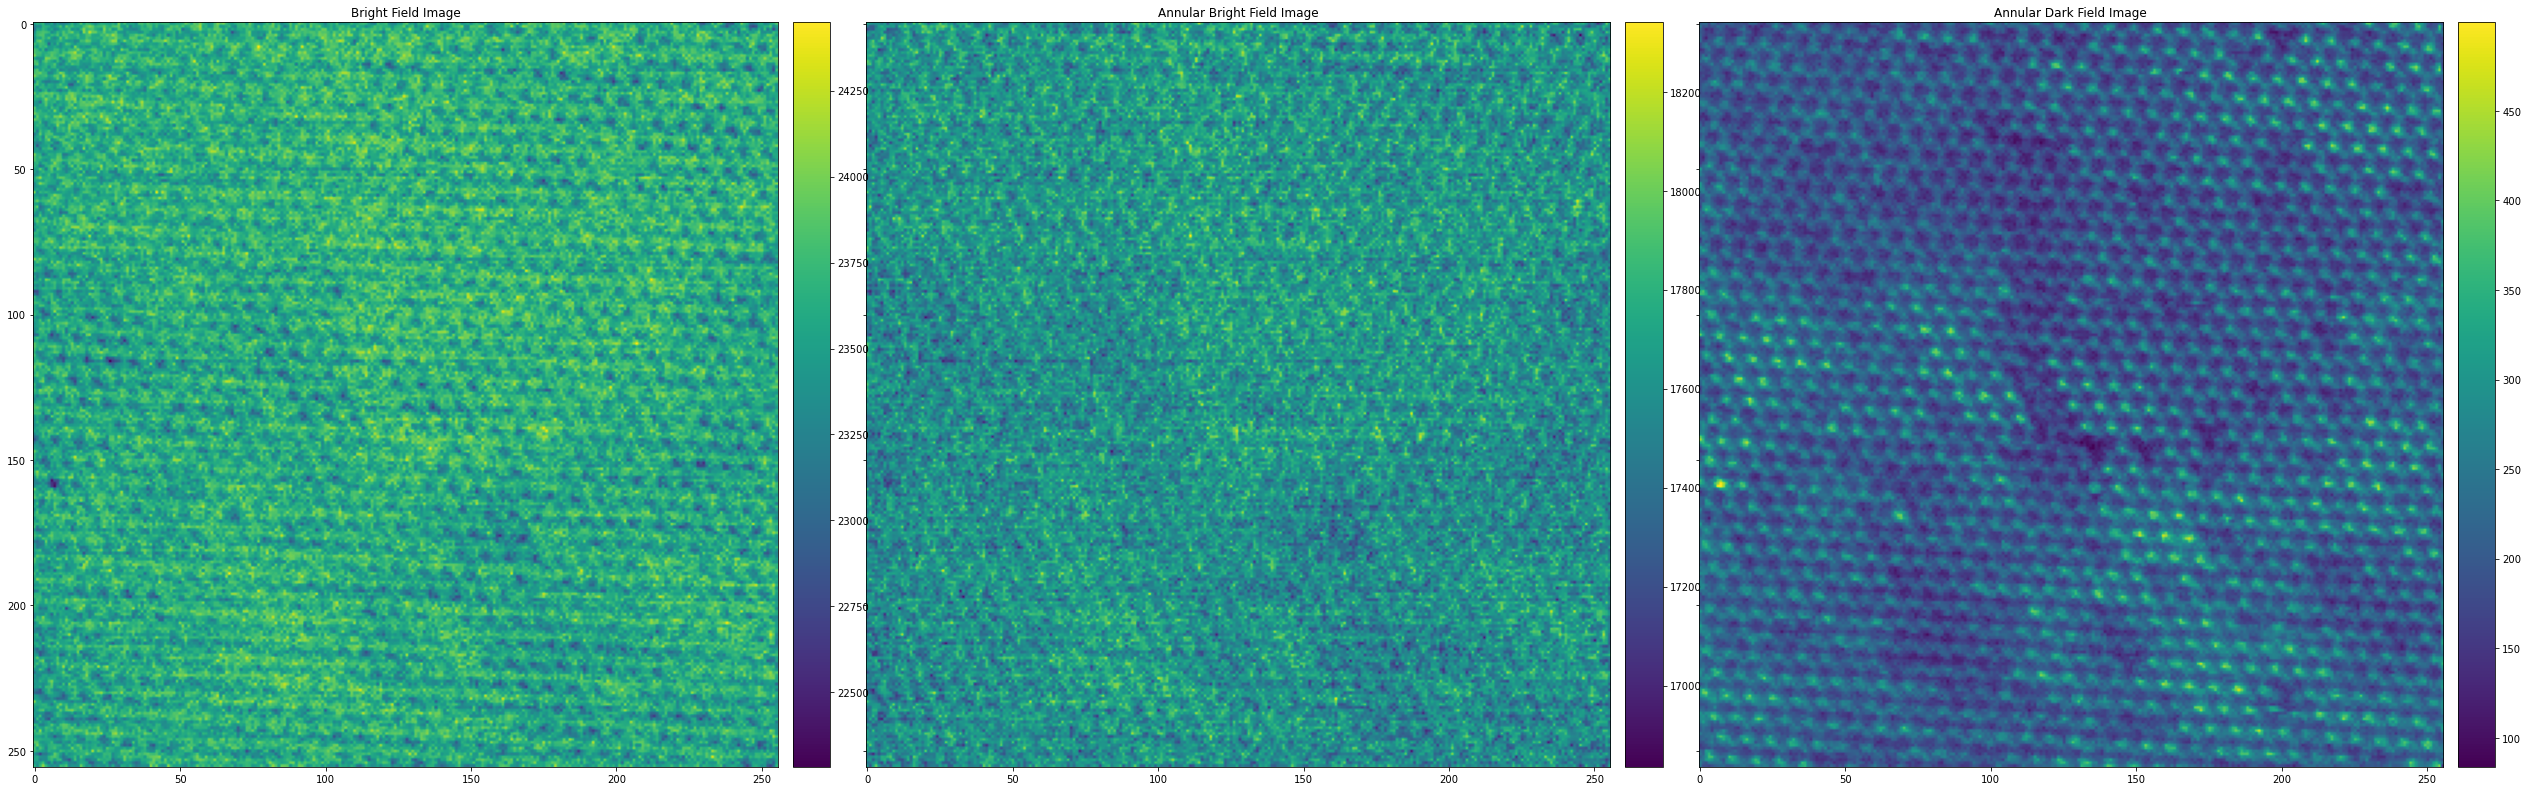

In [5]:
radius_map = np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)
BFMask = radius_map < radius
ABFMask = radius_map < (radius/2)
ADFMask = radius_map > radius*1.2
#get the half of the aperture to compute ABF
BFImage = np.zeros(dat4d.shape[0:2], np.float32)
ABFImage= np.zeros(dat4d.shape[0:2], np.float32)
ADFImage= np.zeros(dat4d.shape[0:2], np.float32)
for i in range(dat4d.shape[0]):
    for j in range(dat4d.shape[1]):
        BFImage[i, j] = np.sum(dat4d[i,j,:,:]*BFMask)
        ABFImage[i, j] = np.sum(dat4d[i,j,:,:]*ABFMask)
        ADFImage[i, j] = np.sum(dat4d[i,j,:,:]*ADFMask)
ABFImage = BFImage-ABFImage
#np.save(folder+'ADF.npy', ADFImage)
#np.save(folder+'ABF.npy', ABFImage)
#np.save(folder+'BF.npy', BFImage)
#Show the STEM images.
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(BFImage, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Bright Field Image")
im=grid[1].imshow(ABFImage, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Annular Bright Field Image")
im=grid[2].imshow(ADFImage, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Annular Dark Field Image")

In [6]:
#normalize the intensity of each line.
ratio = 1.0/np.average(dat4d, axis= (2, 3))
ratio = np.reshape(ratio, (dat4d.shape[0], dat4d.shape[1],1,1))
#trim the 4D-STEM dataset to reduce the computation time.
expansion = 1.2
x_start = int(x_center-expansion*radius)
y_start = int(y_center-expansion*radius)
x_end = int(x_center+expansion*radius)
y_end = int(y_center+expansion*radius)
dat4d_trim=dat4d[:,:,y_start:y_end,x_start:x_end]*ratio
pacbed_trim = pacbed[y_start:y_end,x_start:x_end]
BFdisk = mpacbed[y_start:y_end,x_start:x_end] > 0.5
#compute the center and grid mesh.
x_ctrim = x_center - x_start
y_ctrim = y_center - y_start
Y_trim, X_trim = np.indices(pacbed_trim.shape)

Text(0.5, 1.0, 'Aperture outline')

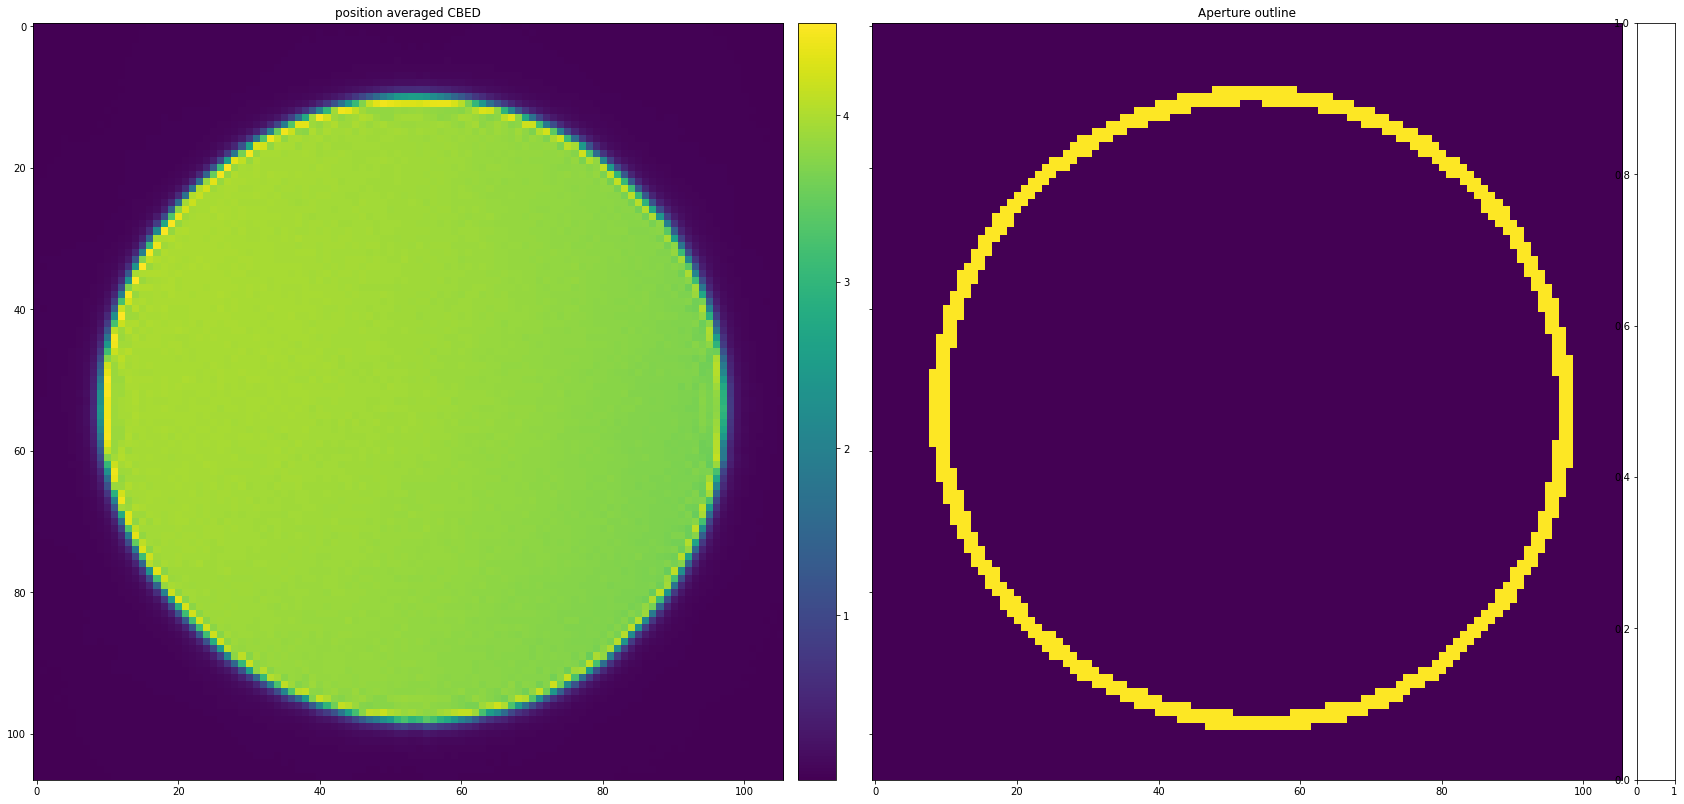

In [7]:
#get the pixels inside the aperture and get the outline of aperture.
thresh = 0.2
pacbed_grad = np.sum(np.abs(np.gradient(pacbed_trim)), axis=0)
aper_outline = np.where(pacbed_grad > np.max(pacbed_grad)*thresh)
outline = np.zeros_like(pacbed_grad)
outline[aper_outline] = 1.0
fig =plt.figure(1, figsize=(100, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed_trim, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(outline, cmap=plt.cm.viridis)
#grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Aperture outline")

In [8]:
def FFT_2D (array):
    result=np.fft.fft2(array)
    result=np.fft.fftshift(result)
    return result
def IFFT_2D (array):
    result=np.fft.ifftshift(array)
    result=np.fft.ifft2(result)
    return result

In [9]:
dat4D_Reci=np.zeros(dat4d_trim.shape,dtype=complex)
for i in range (dat4d_trim.shape[2]):
    for j in range (dat4d_trim.shape[3]):
        dat4D_Reci[:,:,i,j]=FFT_2D(dat4d_trim[:,:,i,j])

In [10]:
power_spectra =np.zeros((dat4D_Reci.shape[0],dat4D_Reci.shape[1]))
for i in range (dat4D_Reci.shape[0]):
    for j in range (dat4D_Reci.shape[1]):
        g=dat4D_Reci[i,j,:,:]
        power_spectra[i,j]=np.sum(g*np.conjugate(g)).real

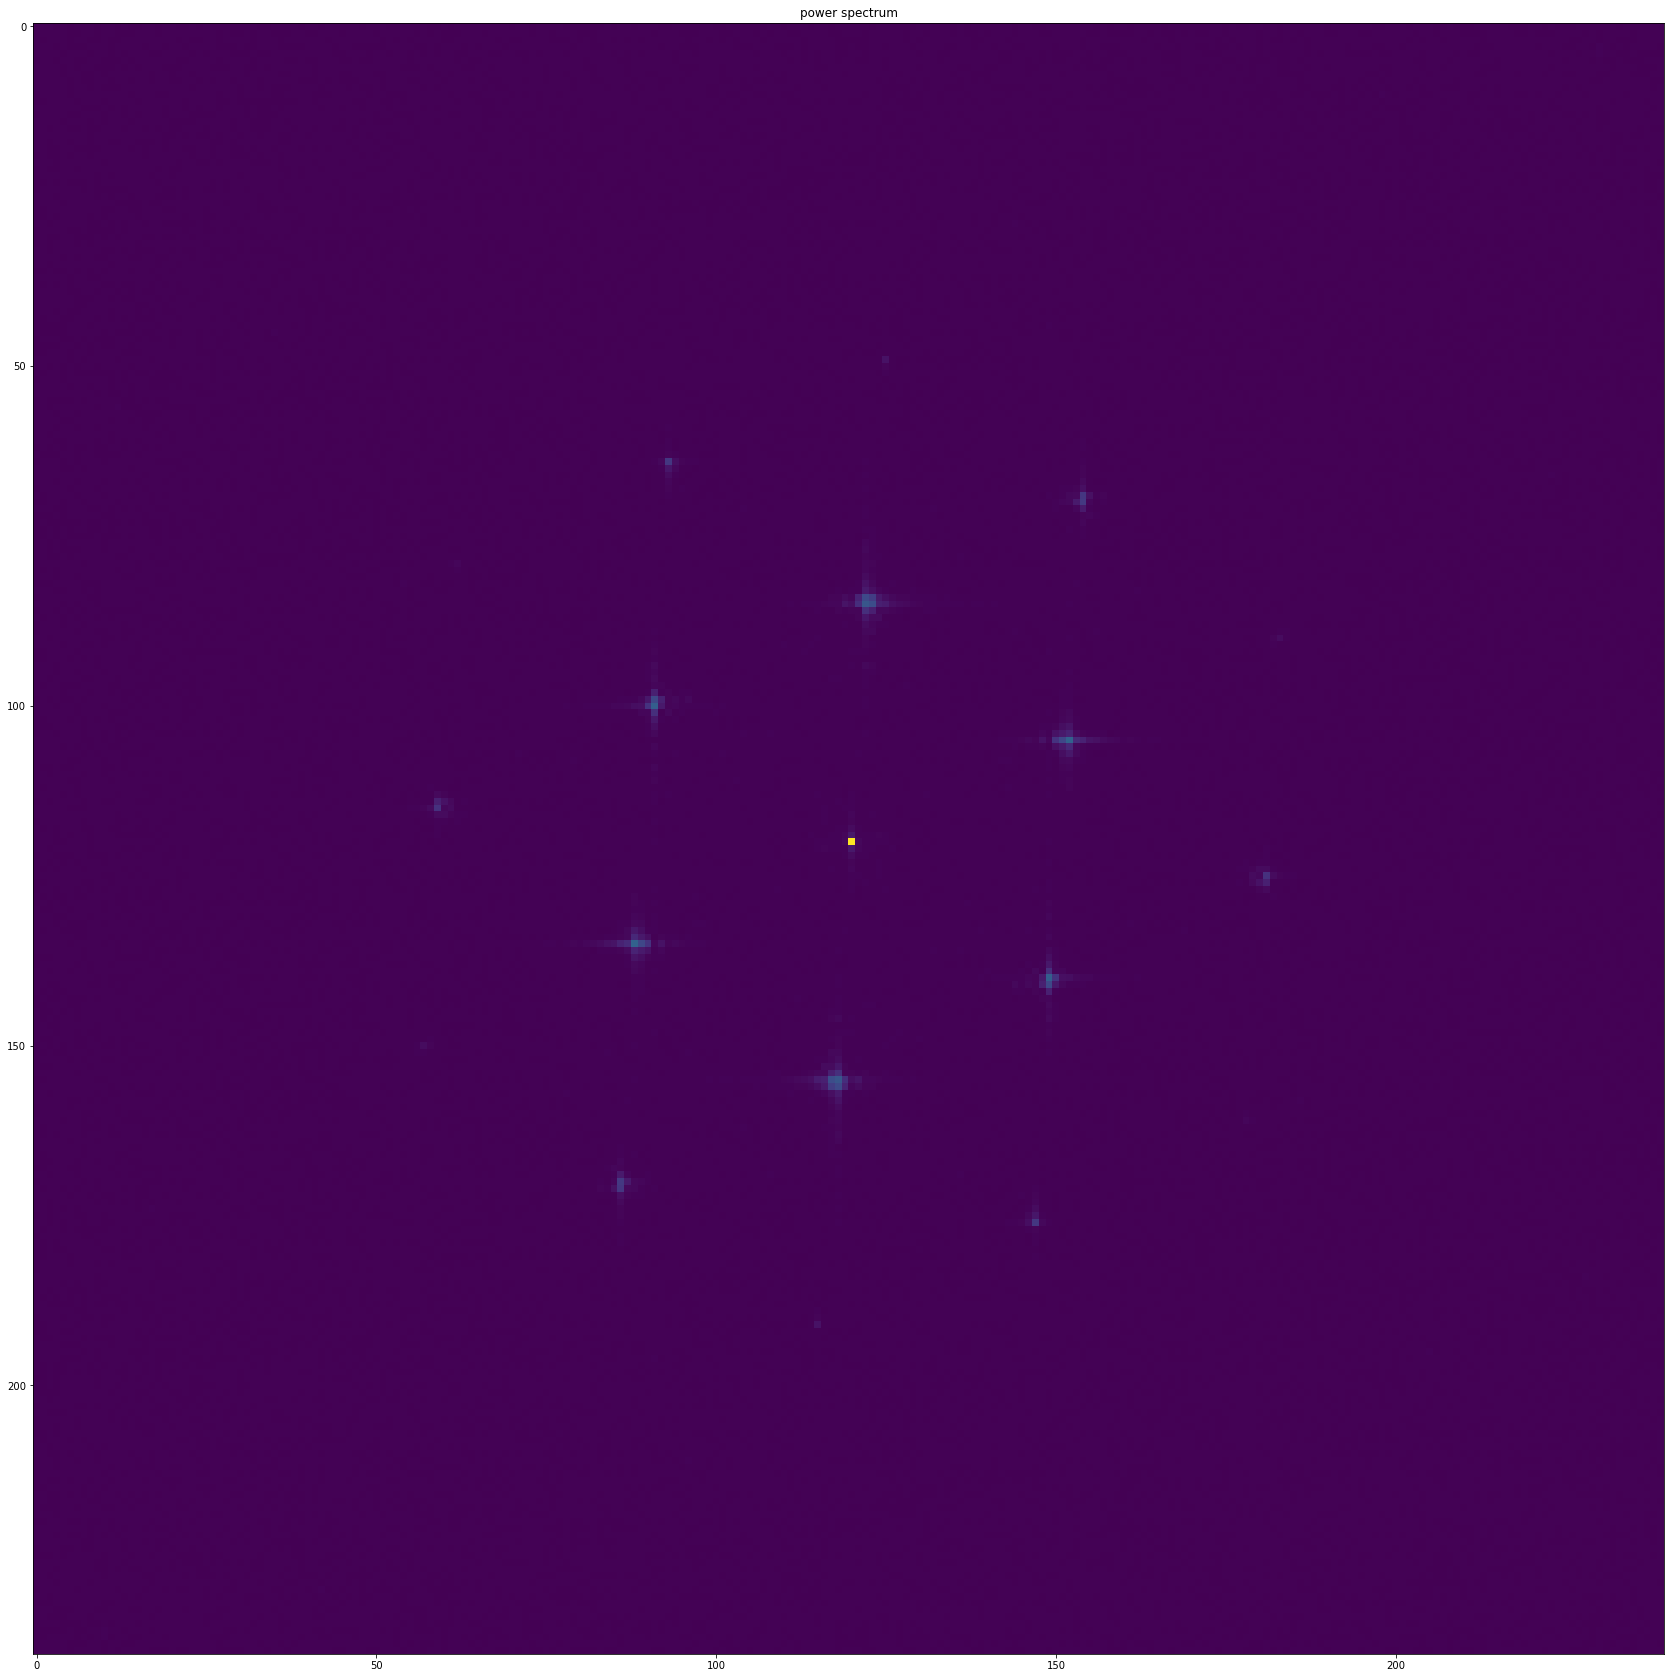

In [11]:
#plot the power spectrum
box = 120
pcenter_x = int(dat4D_Reci.shape[1]/2)
pcenter_y = int(dat4D_Reci.shape[0]/2)
dcenter_x = int(dat4D_Reci.shape[3]/2)
dcenter_y = int(dat4D_Reci.shape[2]/2)
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 111, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=True,
             cbar_location="right",
             cbar_mode="share",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.log(power_spectra[pcenter_y-box:pcenter_y+box,pcenter_x-box:pcenter_x+box]*1e6+1))
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("power spectrum")
np.save(folder + "power_spectra.npy", power_spectra)

In [12]:
#determine the index of reciprocal positions with the largest intensity
power_spectra[pcenter_y, pcenter_x+1] = 0
power_spectra[pcenter_y, pcenter_x-1] = 0
power_spectra[pcenter_y, pcenter_x+2] = 0
power_spectra[pcenter_y, pcenter_x-2] = 0
power_spectra[pcenter_y, pcenter_x+3] = 0
power_spectra[pcenter_y, pcenter_x-3] = 0
power_spectra[pcenter_y, pcenter_x+4] = 0
power_spectra[pcenter_y, pcenter_x-4] = 0
power_spectra[pcenter_y+1, pcenter_x] = 0
power_spectra[pcenter_y-1, pcenter_x] = 0
power_spectra[pcenter_y+2, pcenter_x] = 0
power_spectra[pcenter_y-2, pcenter_x] = 0
power_spectra[pcenter_y+3, pcenter_x] = 0
power_spectra[pcenter_y-3, pcenter_x] = 0
power_spectra[pcenter_y+4, pcenter_x] = 0
power_spectra[pcenter_y-4, pcenter_x] = 0
#peak = power_spectra[pcenter_y, pcenter_x]
#power_spectra[(pcenter_y-15):(pcenter_y+16), (pcenter_x-15):(pcenter_x+16)] = 0
#power_spectra[pcenter_y, pcenter_x] = peak
idx=np.unravel_index(np.argsort(power_spectra, axis=None), power_spectra.shape)
descend_idx=(idx[0][::-1],idx[1][::-1])
print(descend_idx[0][1:37]-pcenter_y)
print(descend_idx[1][1:37]-pcenter_x)

[ 15 -15 -20  20  35 -35  35 -35  36 -36 -21  21  15 -15 -36  36  50 -50
 -56  56 -51  51 -20  20 -15  15   5  -5  34 -34 -19  19 -35  35 -15  15]
[-32  32 -29  29  -2   2  -3   3  -2   2 -29  29 -31  31   3  -3 -34  34
 -27  27  34 -34 -30  30  30 -30  61 -61  -2   2 -29  29   1  -1  33 -33]


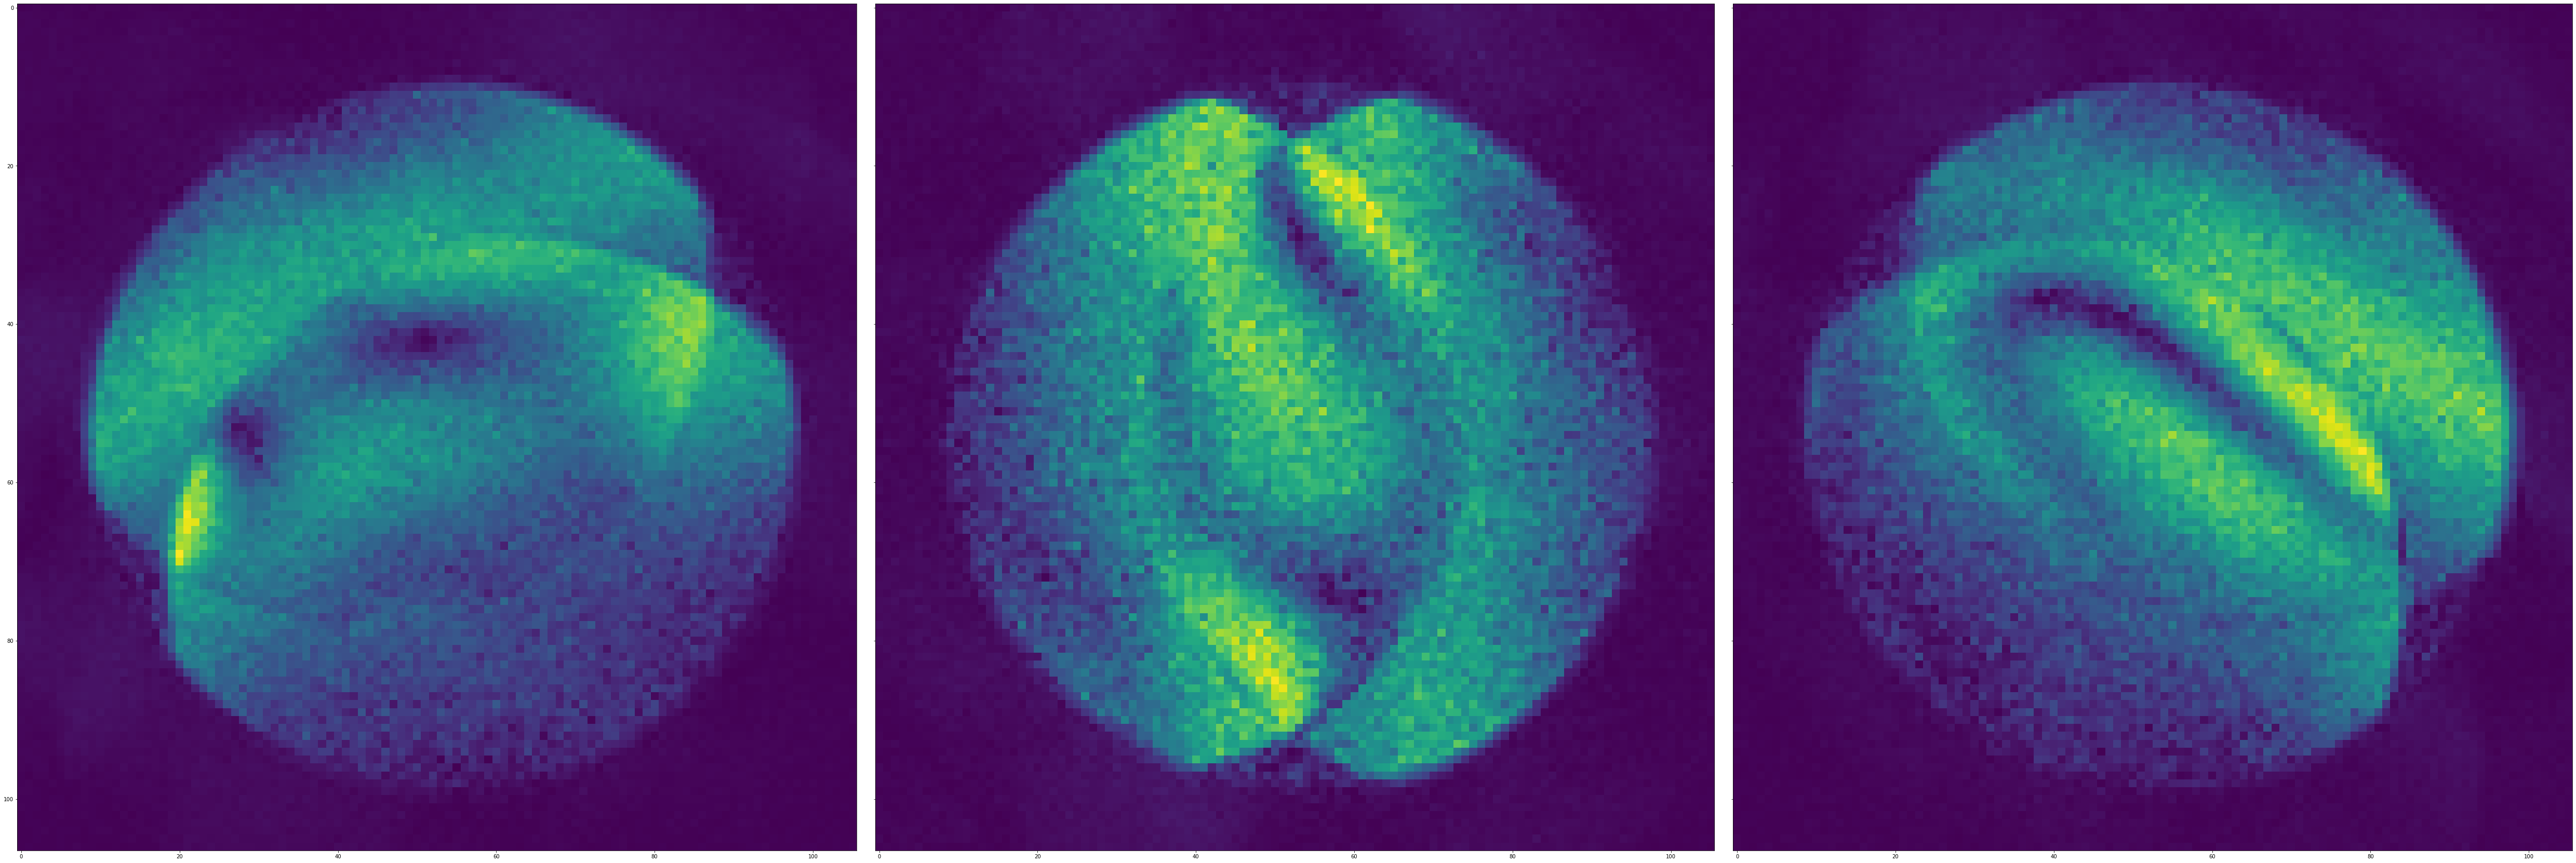

In [13]:
idx_i = [ 15, 35, 20]
idx_j = [-32, -2, 29]
fig =plt.figure(1, figsize=(90, 30))
grid=AxesGrid(fig, 111, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=True,
             cbar_location="right",
             cbar_mode="share",
             cbar_size="5%",
             cbar_pad="2%")
for i in range(3):
    im = grid[i].imshow(np.abs(dat4D_Reci[idx_i[i] + pcenter_y, idx_j[i] + pcenter_x,:,:]))

Text(0.5, 1.0, 'side bands')

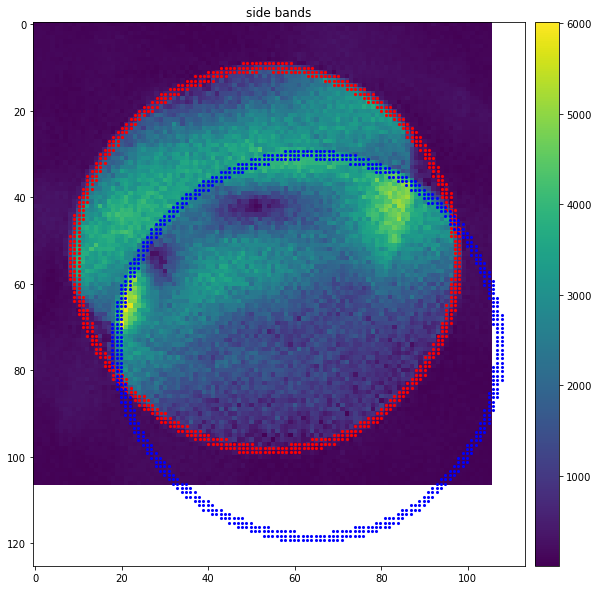

In [14]:
angle1 = 1.12
dist1 = 22.5
fig =plt.figure(1, figsize=(10, 10))
grid=AxesGrid(fig, 111, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
slice1 = np.abs(dat4D_Reci[idx_i[0]+pcenter_y,idx_j[0]+pcenter_x,:,:])
im=grid[0].imshow(slice1)
grid.cbar_axes[0].colorbar(im)
grid[0].scatter(aper_outline[1], aper_outline[0], linewidth=0.2, color = 'red', marker = ".")
grid[0].scatter(aper_outline[1] + dist1*np.cos(angle1), aper_outline[0] + dist1*np.sin(angle1), linewidth=0.1, color = 'blue', marker = ".")
grid[0].set_title('side bands')

Text(0.5, 1.0, 'side bands')

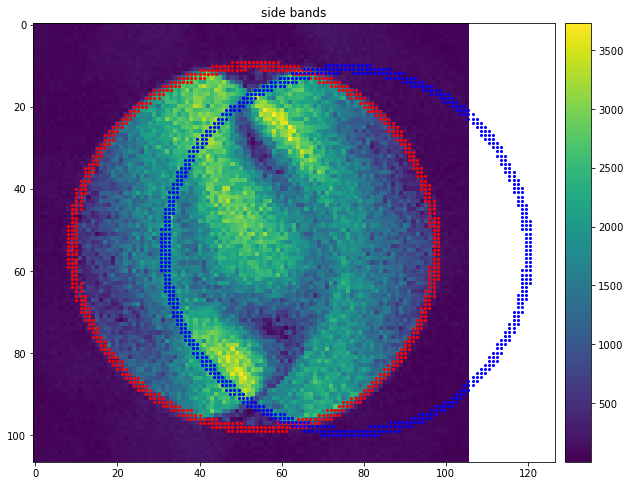

In [15]:
angle2 = 0.04
dist2 = 22.5
fig =plt.figure(1, figsize=(10, 10))
grid=AxesGrid(fig, 111, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
slice2 = np.abs(dat4D_Reci[idx_i[1]+pcenter_y,idx_j[1]+pcenter_x,:,:])
im=grid[0].imshow(slice2)
grid.cbar_axes[0].colorbar(im)
grid[0].scatter(aper_outline[1], aper_outline[0], linewidth=0.2, color = 'red', marker = ".")
grid[0].scatter(aper_outline[1] + dist2*np.cos(angle2), aper_outline[0] + dist2*np.sin(angle2), linewidth=0.1, color = 'blue', marker = ".")
grid[0].set_title('side bands')

Text(0.5, 1.0, 'side bands')

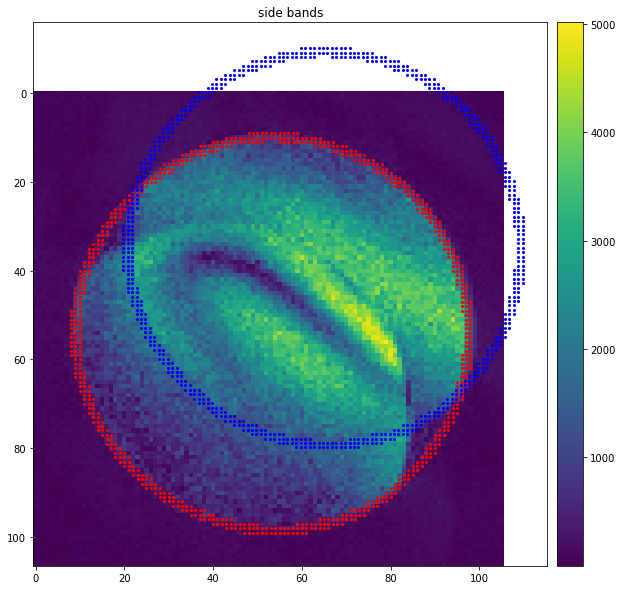

In [16]:
angle3 = -1.02
dist3 = 22.5
fig =plt.figure(1, figsize=(10, 10))
grid=AxesGrid(fig, 111, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
slice3 = np.abs(dat4D_Reci[idx_i[2]+pcenter_y,idx_j[2]+pcenter_x,:,:])
im=grid[0].imshow(slice3)
grid.cbar_axes[0].colorbar(im)
grid[0].scatter(aper_outline[1], aper_outline[0], linewidth=0.2, color = 'red', marker = ".")
grid[0].scatter(aper_outline[1] + dist3*np.cos(angle3), aper_outline[0] + dist3*np.sin(angle3), linewidth=0.1, color = 'blue', marker = ".")
grid[0].set_title('side bands')

In [17]:
def ShiftTrotterFast(mask,dx,dy):
    #the expanded part should be large enough.
    x_shift = int(np.round(dx))
    y_shift = int(np.round(dy))
    if (np.abs(x_shift)>=mask.shape[1])|(np.abs(y_shift)>=mask.shape[0]):
        return np.zeros((mask.shape[0],mask.shape[1]), mask.dtype)
    else:
        expanded = np.zeros((mask.shape[0]*3,mask.shape[1]*3), mask.dtype)
        expanded[mask.shape[0]:2*mask.shape[0],mask.shape[1]:2*mask.shape[1]]=mask
        return expanded[(mask.shape[0]-y_shift):(2*mask.shape[0]-y_shift),(mask.shape[1]-x_shift):(2*mask.shape[1]-x_shift)]
def ShiftDisk(frame,dx,dy):
    expanded = np.zeros((frame.shape[0]*5,frame.shape[1]*5), frame.dtype)
    expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]=frame
    reci_frame=np.fft.fftshift(np.fft.fft2(expanded))
    x_start = -int(expanded.shape[1]/2)
    y_start = -int(expanded.shape[0]/2)
    x_end = x_start + expanded.shape[1]
    y_end = y_start + expanded.shape[0]
    X, Y = np.meshgrid(np.arange(x_start, x_end),np.arange(y_start,y_end))
    X=X*(1.0/expanded.shape[1])
    Y=Y*(1.0/expanded.shape[0])
    reci_frame=reci_frame*np.exp(-2j*np.pi*(dx*X+dy*Y))
    expanded = np.real(np.fft.ifft2(np.fft.ifftshift(reci_frame)))
    return expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]
def GradMaximizer(params, gradt, pacbed_grad):
    dist = params[0]
    angle = params[1]
    disk1 = ShiftDisk(pacbed_grad, dist*np.cos(angle), dist*np.sin(angle))
    disk2 = ShiftDisk(pacbed_grad,-dist*np.cos(angle),-dist*np.sin(angle))
    mask = np.where((disk1 > np.max(pacbed_grad)*thresh) | (disk2 > np.max(pacbed_grad)*thresh))
    grad_temp = np.abs(gradt)
    grad_temp[mask] = 0.0
    return np.sum(grad_temp)

In [18]:
pacbed_grad[np.where(pacbed_grad < np.max(pacbed_grad)*thresh)] = 0
#automatic optimization of the above parameters by assuming the aperture is a rounded shape.
trotter_params1 = np.asarray([dist1, angle1])
slices_grad = np.sqrt(np.sum(np.square(np.gradient(slice1)), axis = 0))
slices_grad[np.where(slices_grad < np.max(slices_grad)*thresh)] = 0
trotter_params1 = optimize.minimize(GradMaximizer, trotter_params1, args=(slices_grad, pacbed_grad), method='Nelder-Mead').x
print(trotter_params1)
#the second one.
trotter_params2 = np.asarray([dist2, angle2])
slices_grad = np.sqrt(np.sum(np.square(np.gradient(slice2)), axis = 0))
slices_grad[np.where(slices_grad < np.max(slices_grad)*thresh)] = 0
trotter_params2 = optimize.minimize(GradMaximizer, trotter_params2, args=(slices_grad, pacbed_grad), method='Nelder-Mead').x
print(trotter_params2)
#the third one.
trotter_params3 = np.asarray([dist3, angle3])
slices_grad = np.sqrt(np.sum(np.square(np.gradient(slice3)), axis = 0))
slices_grad[np.where(slices_grad < np.max(slices_grad)*thresh)] = 0
trotter_params3 = optimize.minimize(GradMaximizer, trotter_params3, args=(slices_grad, pacbed_grad), method='Nelder-Mead').x
print(trotter_params3)

[21.91957667  1.11131753]
[24.02842247  0.04198238]
[23.90625 -0.9945 ]


In [19]:
angle1 = trotter_params1[1]
angle2 = trotter_params2[1]
angle3 = trotter_params3[1]
#solve the equation group.
def equations(params):
    theta_x, theta_y, ratio = params
    eq1 = np.sin(angle1)*(idx_j[0]*np.cos(theta_x)-idx_i[0]*np.sin(theta_y)*ratio) - np.cos(angle1)*(idx_j[0]*np.sin(theta_x)+idx_i[0]*np.cos(theta_y)*ratio)
    eq2 = np.sin(angle2)*(idx_j[1]*np.cos(theta_x)-idx_i[1]*np.sin(theta_y)*ratio) - np.cos(angle2)*(idx_j[1]*np.sin(theta_x)+idx_i[1]*np.cos(theta_y)*ratio)
    eq3 = np.sin(angle3)*(idx_j[2]*np.cos(theta_x)-idx_i[2]*np.sin(theta_y)*ratio) - np.cos(angle3)*(idx_j[2]*np.sin(theta_x)+idx_i[2]*np.cos(theta_y)*ratio)
    return (eq1, eq2, eq3)
theta_x, theta_y, gama =  fsolve(equations, (3.0, 3.0, 1.0))
print(theta_x, theta_y, gama)
theta_y = theta_y + np.pi/2

-1.597455792687895 -1.5863827704806017 0.9908103712836189


Text(0.5, 1.0, 'side bands')

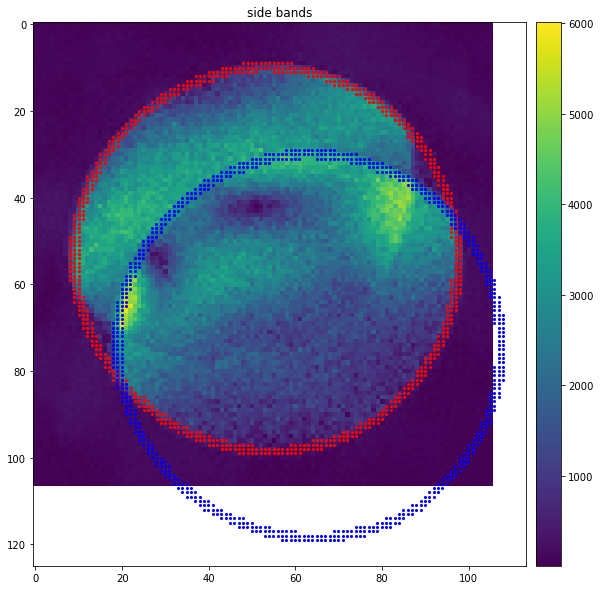

In [20]:
#compute the rotation angle and length of reciprocal scanning vector
#For any diffracton frame indexed as: [center_y+ i, center_x + j]
#the shift vector is: j*kx+i*ky = j*dl*(cos(theta_x), sin(theta_x)) + i*dl*gama*(cos(theta_y), sin(theta_y))=(dx, dy)
dl = 0.63
slice_idx = 0
shift_x = dl*(idx_j[slice_idx]*np.cos(theta_x)+idx_i[slice_idx]*np.cos(theta_y)*gama)
shift_y = dl*(idx_j[slice_idx]*np.sin(theta_x)+idx_i[slice_idx]*np.sin(theta_y)*gama)
RMask = ShiftTrotterFast(BFdisk,shift_x,shift_y)
LMask = ~ShiftTrotterFast(BFdisk,-shift_x,-shift_y)
FFT_Frame =  dat4D_Reci[idx_i[slice_idx]+pcenter_y,idx_j[slice_idx]+pcenter_x,:,:].copy()
#FFT_Frame[np.where(RMask&LMask&BFdisk)] = 0
fig =plt.figure(1, figsize=(10, 10))
grid=AxesGrid(fig, 111, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.abs(FFT_Frame))
grid.cbar_axes[0].colorbar(im)
grid[0].scatter(aper_outline[1], aper_outline[0], linewidth=0.2, color = 'red', marker = ".")
grid[0].scatter(aper_outline[1]+shift_x, aper_outline[0]+shift_y, linewidth=0.1, color = 'blue', marker = ".")
grid[0].set_title('side bands')

In [21]:
#NION nomination
# For weak phase object: G(Kf,Qp) = |A(Kf)|^2.*delta(Qp) + A(Kf-Qp)A.*(Kf)Psi_s(Qp) +  A(Kf)A.*(Kf+Qp)Psi_s.*(-Qp);
# the phase of left trotter A(Kf-Qp)A.*(Kf)Psi_s(Qp) equals to:
# chi(A(Kf-Qp)) - chi(A(Kf)) + phase(Psi_s(Qp))
def GenAMatrix(freq_x, freq_y, tshift_x, tshift_y, pixel_idx, order):
    #transfrom to 1D array.
    kx = freq_x[pixel_idx]
    ky = freq_y[pixel_idx]
    kx2=kx*kx
    ky2=ky*ky
    kx3=kx2*kx
    ky3=ky2*ky
    kx4=kx3*kx
    ky4=ky3*ky
    kx5=kx4*kx
    ky5=ky4*ky
    kx6=kx5*kx
    ky6=ky5*ky
    kx7=kx6*kx
    ky7=ky6*ky
    k2=kx2+ky2
    k4=k2*k2
    k6=k4*k2
    
    sx=kx-tshift_x
    sy=ky-tshift_y
    sx2=sx*sx
    sy2=sy*sy
    sx3=sx2*sx
    sy3=sy2*sy
    sx4=sx3*sx
    sy4=sy3*sy
    sx5=sx4*sx
    sy5=sy4*sy
    sx6=sx5*sx
    sy6=sy5*sy
    sx7=sx6*sx
    sy7=sy6*sy
    s2=sx2+sy2
    s4=s2*s2
    s6=s4*s2
    #defocus and first order stigma:0-2
    AMatrix=s2-k2,(sx2-sy2)-(kx2-ky2),(sx*sy-kx*ky)*2.0
    AMatrix=np.asarray(AMatrix)/2.0
    #Coma and second order stigma: 3-6
    if order>1:
        Matrix2nd=sx*s2-kx*k2,sy*s2-ky*k2,(sx3-3.0*sx*sy2)-(kx3-3.0*kx*ky2),(3.0*sx2*sy-sy3)-(3.0*kx2*ky-ky3)
        AMatrix=np.concatenate((AMatrix, np.asarray(Matrix2nd)/3.0), axis=0)
    #C3 and Third order stigma, Star aberrations: 7-11
    if order>2:
        Matrix3rd=s4-k4,(sx2-sy2)*s2-(kx2-ky2)*k2,2.0*sx*sy*s2-2.0*kx*ky*k2, (sx4-6.0*sx2*sy2+sy4)-(kx4-6.0*kx2*ky2+ky4),(4.0*sx*sy3-4.0*sx3*sy)-(4.0*kx*ky3-4.0*kx3*ky)
        AMatrix=np.concatenate((AMatrix, np.asarray(Matrix3rd)/4.0), axis=0)
    #Fourth order, 12-17
    if order>3:
        Matrix4th=sx*s4-kx*k4,sy*s4-ky*k4,(sx3-3.0*sx*sy2)*s2-(kx3-3.0*kx*ky2)*k2,(3.0*sx2*sy-sy3)*s2-(3.0*kx2*ky-ky3)*k2,(sx5-10.0*sx3*sy2+5.0*sx*sy4)-(kx5-10.0*kx3*ky2+5.0*kx*ky4), (10.0*sx2*sy3-5.0*sx4*sy-sy5)-(10.0*kx2*ky3-5.0*kx4*ky-ky5)
        AMatrix=np.concatenate((AMatrix, np.asarray(Matrix4th)/5.0), axis=0)
    #Fifth order, C5, 18-24
    if order>4:
        Matrix5th=s6-k6,(sx2-sy2)*s4-(kx2-ky2)*k4,2.0*sx*sy*s4-2.0*kx*ky*k4, (sx4-6.0*sx2*sy2+sy4)*s2-(kx4-6.0*kx2*ky2+ky4)*k2,(4.0*sx*sy3-4.0*sx3*sy)*s2-(4.0*kx*ky3-4.0*kx3*ky)*k2,(sx6-sy6-15.0*sx4*sy2+15.0*sx2*sy4)-(kx6-ky6-15.0*kx4*ky2+15.0*kx2*ky4),(20.0*sx3*sy3-6.0*sx5*sy-6.0*sx*sy5)-(20.0*kx3*ky3-6.0*kx5*ky-6.0*kx*ky5)
        AMatrix=np.concatenate((AMatrix, np.asarray(Matrix5th)/6.0), axis=0)
    #Six order, A6, 25-32
    if order>5:
        Matrix6th=sx*s6-kx*k6,sy*s6-ky*k6,(sx3-3.0*sx*sy2)*s4-(kx3-3.0*kx*ky2)*k4,(3.0*sx2*sy-sy3)*s4-(3.0*kx2*ky-ky3)*k4,((sx5-10.0*sx3*sy2+5.0*sx*sy4)*s2-(kx5-10.0*kx3*ky2+5.0*kx*ky4))*k2, ((10.0*sx2*sy3-5.0*sx4*sy-sy5)*s2-(10.0*kx2*ky3-5.0*kx4*ky-ky5))*k2,(sx7-21.0*sx5*sy2+35.0*sx3*sy4-7.0*sx*sy6)-(kx7-21.0*kx5*ky2+35.0*kx3*ky4-7.0*kx*ky6), (7.0*sx6*sy-35.0*sx4*sy3+21.0*sy2*sy5-sy7)-(7.0*kx6*ky-35.0*kx4*ky3+21.0*ky2*ky5-ky7)
        AMatrix=np.concatenate((AMatrix, np.asarray(Matrix6th)/7.0), axis=0)
    return AMatrix
def PhaseShift(freq_x, freq_y, tshift_x, tshift_y, aberrations, order):
    """
    freq_x:detector spatial frequency x
    freq_y:detector spatial frequency y
    
    output:
    Chi function
    """
    kx = freq_x+tshift_x
    ky = freq_y+tshift_y
    kx2=kx*kx
    ky2=ky*ky
    kx3=kx2*kx
    ky3=ky2*ky
    kx4=kx3*kx
    ky4=ky3*ky
    kx5=kx4*kx
    ky5=ky4*ky
    kx6=kx5*kx
    ky6=ky5*ky
    kx7=kx6*kx
    ky7=ky6*ky
    k2=kx2+ky2
    k4=k2*k2
    k6=k4*k2
    C1   = aberrations[0]
    C12a = aberrations[1]
    C12b = aberrations[2]
    phase_shift= (C1*k2+C12a*(kx2-ky2)+2.0*C12b*kx*ky)/2.0
    if order>1:
        C21a = aberrations[3]
        C21b = aberrations[4]
        C23a = aberrations[5]
        C23b = aberrations[6]
        phase_shift+= ((C21a*kx+C21b*ky)*k2+C23a*(kx3-3.0*kx*ky2)+C23b*(3.0*kx2*ky-ky3))/3.0
    if order>2:
        C3   = aberrations[7]
        C32a = aberrations[8]
        C32b = aberrations[9]
        C34a = aberrations[10]
        C34b = aberrations[11]
        phase_shift+= (C3*k4+(C32a*(kx2-ky2)+2.0*C32b*kx*ky)*k2+C34a*(kx4-6.0*kx2*ky2+ky4)+C34b*(4.0*kx*ky3-4.0*kx3*ky))/4.0
    if order>3:
        C41a = aberrations[12]
        C41b = aberrations[13]
        C43a = aberrations[14]
        C43b = aberrations[15]
        C45a = aberrations[16]
        C45b = aberrations[17]
        phase_shift+= ((C41a*kx+C41b*ky)*k4+(C43a*(kx3-3.0*kx*ky2)+C43b*(3.0*kx2*ky-ky3))*k2+C45a*(kx5-10.0*kx3*ky2+5.0*kx*ky4)+C45b*(10.0*kx2*ky3-5.0*kx4*ky-ky5))/5.0
    if order>4:
        C5 = aberrations[18]
        C52a = aberrations[19]
        C52b = aberrations[20]
        C54a = aberrations[21]
        C54b = aberrations[22]
        C56a = aberrations[23]
        C56b = aberrations[24]
        phase_shift+= (C5*k6+(C52a*(kx2-ky2)+2.0*C52b*kx*ky)*k4+(C54a*(kx4-6.0*kx2*ky2+ky4)+C54b*(4.0*kx*ky3-4.0*kx3*ky))*k2+C56a*(kx6-ky6-15.0*kx4*ky2+15.0*kx2*ky4)+C56b*(20.0*kx3*ky3-6.0*kx5*ky-6.0*kx*ky5))/6.0
    if order>5:
        C61a = aberrations[25]
        C61b = aberrations[26]
        C63a = aberrations[27]
        C63b = aberrations[28]
        C65a = aberrations[29]
        C65b = aberrations[30]
        C67a = aberrations[31]
        C67b = aberrations[32]
        phase_shift+= ((C61a*kx+C61b*ky)*k6+(C63a*(kx3-3.0*kx*ky2)+C63b*(3.0*kx2*ky-ky3))*k4+(C65a*(kx5-10.0*kx3*ky2+5.0*kx*ky4)+C65b*(10.0*kx2*ky3-5.0*kx4*ky-ky5))*k2+C67a*(kx7-21.0*kx5*ky2+35.0*kx3*ky4-7.0*kx*ky6)+C67b*(7.0*kx6*ky-35.0*kx4*ky3+21.0*ky2*ky5-ky7))/7.0
    return phase_shift

In [22]:
freqx_inter = 1.0/dat4D_Reci.shape[3]
freqy_inter = 1.0/dat4D_Reci.shape[2]
x_freq = (X_trim- dcenter_x)*freqx_inter
y_freq = (Y_trim- dcenter_y)*freqy_inter

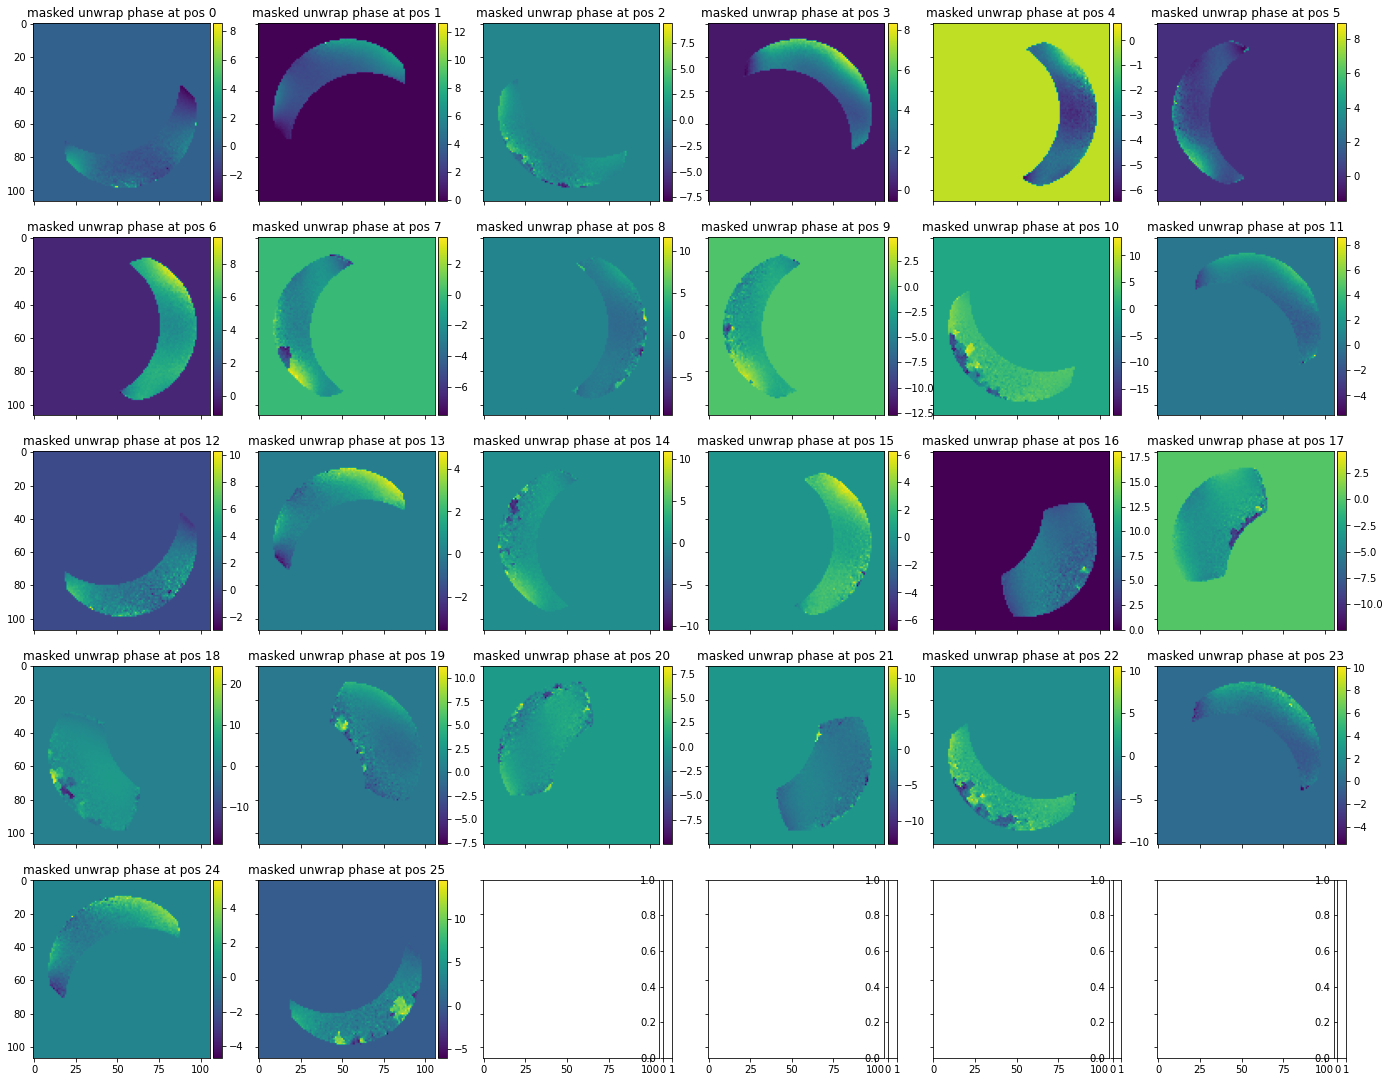

In [23]:
#show the phase distribution of double-overlapped regions for each G-slice
pts_num = 26
unwraps = []
valid_regions = []
fig =plt.figure(1, figsize=(80, 80))
grid=AxesGrid(fig, 236, nrows_ncols=(5,6),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
for ipt in range(pts_num):
    row_idx=descend_idx[0][ipt+1]
    col_idx=descend_idx[1][ipt+1]
    shift_x = col_idx-pcenter_x
    shift_y = row_idx-pcenter_y
    delta_x = dl*(shift_x*np.cos(theta_x)+shift_y*np.cos(theta_y)*gama)
    delta_y = dl*(shift_x*np.sin(theta_x)+shift_y*np.sin(theta_y)*gama)
    RMask = ShiftTrotterFast(BFdisk,delta_x,delta_y)
    LMask = ~ShiftTrotterFast(BFdisk,-delta_x,-delta_y)
    valid_region = np.where(RMask&LMask&BFdisk)
    unwrap = unwrap_phase(np.angle(dat4D_Reci[row_idx,col_idx,:,:]),wrap_around=True)
    masked_phase = np.zeros_like(unwrap)
    masked_phase[valid_region] = unwrap[valid_region]
    valid_regions.append(valid_region)
    unwraps.append(unwrap)
    im=grid[ipt].imshow(masked_phase)
    grid.cbar_axes[ipt].colorbar(im)
    grid[ipt].set_title('masked unwrap phase at pos ' + str(ipt))

In [24]:
#filter the phase inside the double overlapped regions.
#or reduce the valid region of the double overlapped regions.
unwraps = np.asarray(unwraps)
masks = np.zeros_like(unwraps)
for ipt in range(pts_num):
    masks[ipt][valid_regions[ipt]] = 1
np.save("masks.npy", masks)
np.save("unwrap phases.npy", unwraps)

In [26]:
#filter the phase inside the double overlapped regions.
#or reduce the valid region of the double overlapped regions.
masks = np.load("masks reduced.npy")
for ipt in range(pts_num):
    valid_regions[ipt] = np.where(masks[ipt]>0)
#unwraps = np.load("unwrap phases1.npy")

In [27]:
# How to solve the aberration coefficient?
# AX = b;
# A is the construction matrix, 
# X is the aberration coefficient [C1, C12a, C12b, C23a, C23b, C21a, C21b, C3, C34a, C34b, C32a, C32b, Qp1, Qp2.. Qpn]';
# b is the phase{G(Kf,Qp)} inside the double overlapped areas.
order = 5
valid_slices = np.arange(26)
#valid_slices = np.asarray([0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 17, 18])
for ipt in range(valid_slices.shape[0]):
    slice_idx = valid_slices[ipt]
    row_idx=descend_idx[0][slice_idx+1]
    col_idx=descend_idx[1][slice_idx+1]
    shift_x = col_idx-pcenter_x
    shift_y = row_idx-pcenter_y
    delta_x = dl*(shift_x*np.cos(theta_x)+shift_y*np.cos(theta_y)*gama)
    delta_y = dl*(shift_x*np.sin(theta_x)+shift_y*np.sin(theta_y)*gama)
    AMatrixT = GenAMatrix(x_freq, y_freq, delta_x*freqx_inter, delta_y*freqy_inter, valid_regions[slice_idx],order)
    BMatrixT = unwraps[slice_idx][valid_regions[slice_idx]]
    if ipt ==0:
        BMatrix = BMatrixT
        AMatrix = np.zeros((AMatrixT.shape[0]+1,AMatrixT.shape[1]), AMatrixT.dtype)
        AMatrix[0:AMatrixT.shape[0],0:AMatrixT.shape[1]] = AMatrixT
        AMatrix[-1,0:AMatrixT.shape[1]] = 1
    else:
        BMatrix = np.concatenate((BMatrix, BMatrixT))
        AMatrixF = np.zeros((AMatrix.shape[0]+1,AMatrix.shape[1]+AMatrixT.shape[1]), AMatrix.dtype)
        AMatrixF[0:AMatrix.shape[0],0:AMatrix.shape[1]] = AMatrix
        AMatrixF[0:AMatrixT.shape[0], AMatrix.shape[1]:AMatrixF.shape[1]]=AMatrixT
        AMatrixF[-1,AMatrix.shape[1]:AMatrixF.shape[1]] =1
        AMatrix = AMatrixF

In [28]:
BMatrixP = AMatrix.dot(BMatrix)
AMatrixP = np.dot(AMatrix, AMatrix.T)
Aberrations = np.linalg.solve(AMatrixP, BMatrixP)
print(Aberrations)

[ 4.81163840e+01  7.82272260e+00 -2.02761269e+01 -9.77685709e+01
  3.55058377e+01  2.10796044e+01 -1.97506752e+01 -7.93187945e+02
  9.95514318e+01  5.63484568e+02  2.24600674e+02 -1.91601024e+01
  7.84555774e+02  8.26370432e+01  5.90342311e+01 -1.19919218e+02
  9.10925196e+01 -8.73624033e+01  3.74085030e+02 -8.30424609e+02
 -2.45321999e+02 -1.79942024e+03  1.04746451e+02  2.41687522e+02
  8.94044595e+02 -3.28582605e-03  3.48902430e+00  6.78429614e-01
  2.53386120e+00 -4.59148360e+00  1.68273509e+00  4.90785555e+00
 -1.47013699e+00 -1.40417007e+00 -1.60062056e+00  3.64591526e+00
 -5.02924746e-01  2.75038840e+00  4.71618875e-01  1.68327969e+00
  1.64395957e+00  6.50707613e+00 -2.84025572e+00  3.86828072e+00
 -3.99196330e-01  2.32785570e-01 -2.93898985e+00  3.41369069e+00
  3.72953765e-02  1.31016442e-01  3.29955051e+00]


In [29]:
#Refinement using Target function.
#def TargetFun(ABCoeff, A, B):
#    NewB = np.dot(A.T, ABCoeff)%(2*np.pi)
#    return np.sum(np.square(NewB - B))
#Aberrations = optimize.minimize(TargetFun,Aberrations,args=(AMatrix, BMatrixN), method='Nelder-Mead').x

Text(0.5, 1.0, 'masked probe phase')

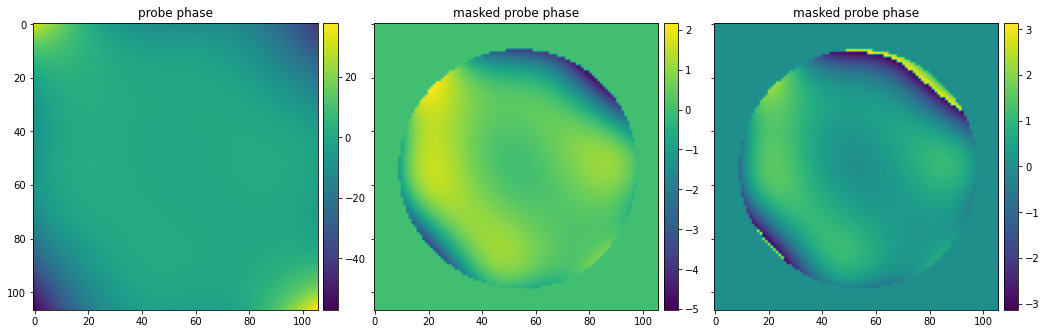

In [30]:
probe_phase= PhaseShift(x_freq, y_freq, 0, 0, Aberrations,order)
masked_phase=probe_phase*BFdisk
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(probe_phase)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('probe phase')
im=grid[1].imshow(masked_phase)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('masked probe phase')
im=grid[2].imshow((masked_phase+np.pi)%(np.pi*2)-np.pi, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title('masked probe phase')

Text(0.5, 1.0, 'corrected')

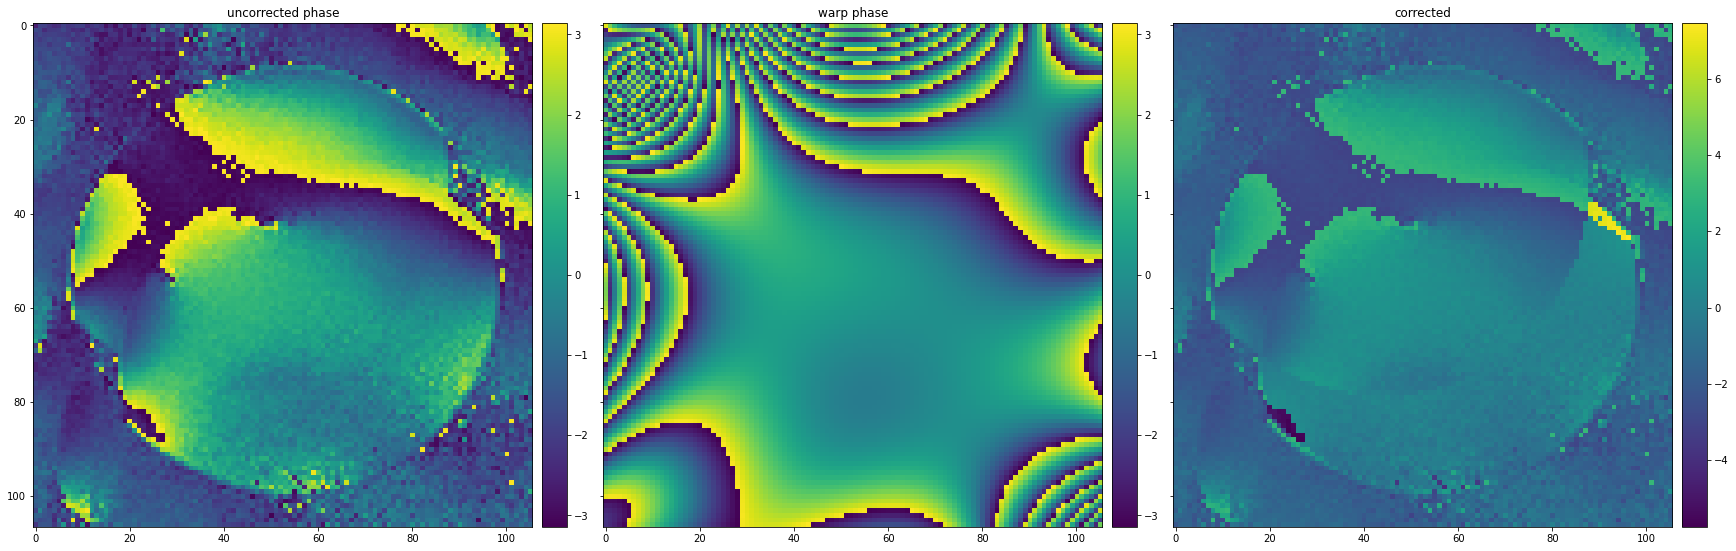

In [31]:
slice_idx = 0
shift_x = dl*(idx_j[slice_idx]*np.cos(theta_x)+idx_i[slice_idx]*np.cos(theta_y)*gama)
shift_y = dl*(idx_j[slice_idx]*np.sin(theta_x)+idx_i[slice_idx]*np.sin(theta_y)*gama)
RMask = ShiftTrotterFast(BFdisk,shift_x,shift_y)
LMask = ~ShiftTrotterFast(BFdisk,-shift_x,-shift_y)
phase_frame = np.angle(dat4D_Reci[idx_i[slice_idx]+pcenter_y,idx_j[slice_idx]+pcenter_x,:,:])
corrected =  PhaseShift(x_freq, y_freq, -shift_x*freqx_inter, -shift_y*freqy_inter, Aberrations,order) - PhaseShift(x_freq, y_freq, 0, 0, Aberrations,order)
trotter_phase = np.zeros_like(corrected)
trotter_phase[np.where(RMask&LMask&BFdisk)] = corrected[np.where(RMask&LMask&BFdisk)]
corrected_warp=np.exp(1j*corrected)
fig =plt.figure(1, figsize=(30, 10))
grid=AxesGrid(fig, 111, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(phase_frame)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('uncorrected phase')
im=grid[1].imshow(np.angle(corrected_warp))
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('warp phase')
im=grid[2].imshow(phase_frame - trotter_phase)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title('corrected')

In [32]:
LTrotterSum = np.zeros(power_spectra.shape,dtype=complex)
RTrotterSum = np.zeros(power_spectra.shape,dtype=complex)
TrotterPixelNum = np.zeros(power_spectra.shape, dtype =int)

In [33]:
#reconstruction without aberration correction.
for i in range (power_spectra.shape[0]):
    print('SSB',int((i+1)/power_spectra.shape[0]*100),'%',end='\r')
    for j in range (power_spectra.shape[1]):
        shift_x = j-pcenter_x
        shift_y = i-pcenter_y
        delta_x = dl*(shift_x*np.cos(theta_x)+shift_y*np.cos(theta_y)*gama)
        delta_y = dl*(shift_x*np.sin(theta_x)+shift_y*np.sin(theta_y)*gama)
        RMask = ShiftTrotterFast(BFdisk,delta_x,delta_y)
        LMask = ~ShiftTrotterFast(BFdisk,-delta_x,-delta_y)
        if (shift_x==0)&(shift_y==0):
            valid_region = np.where(BFdisk)
        else:
            valid_region = np.where(RMask&LMask&BFdisk)
        TrotterPixelNum[i,j] = valid_region[0].shape[0]
        new_frame = dat4D_Reci[i,j,:,:]
        new_frame = new_frame[valid_region]
        if TrotterPixelNum[i,j]>0:
            RTrotterSum[i,j]=np.sum(new_frame)/TrotterPixelNum[i,j]
        else:
            RTrotterSum[i,j]=0

Text(0.5, 1.0, 'Right Trotter amp')

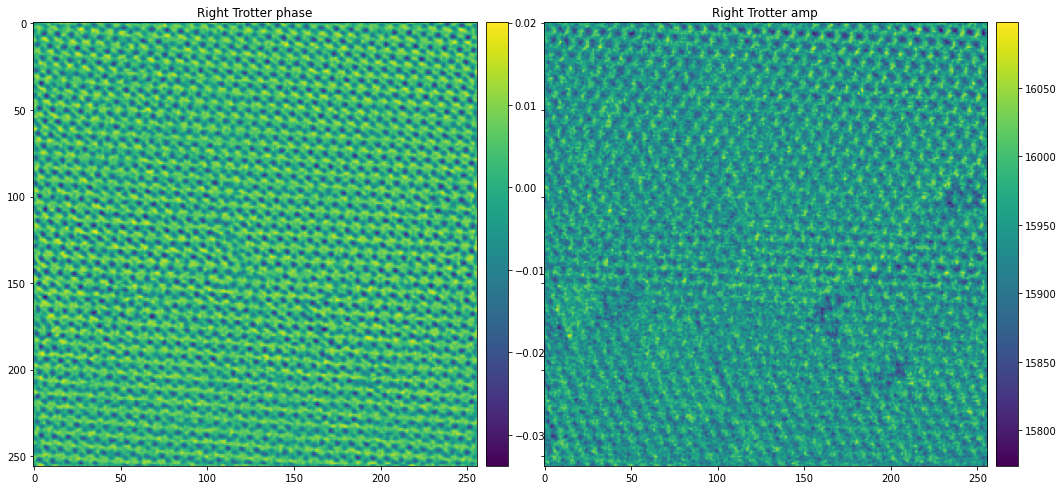

In [34]:
objectR =IFFT_2D(RTrotterSum*TrotterPixelNum)
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.angle(objectR))
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Right Trotter phase')
im=grid[1].imshow(np.abs(objectR))
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Right Trotter amp')

In [35]:
#Then we make aberration correction using determined aberration coefficient in this step
for i in range (power_spectra.shape[0]):
    print('SSB',int((i+1)/power_spectra.shape[0]*100),'%',end='\r')
    for j in range (power_spectra.shape[1]):
        shift_x = j-pcenter_x
        shift_y = i-pcenter_y
        delta_x = dl*(shift_x*np.cos(theta_x)+shift_y*np.cos(theta_y)*gama)
        delta_y = dl*(shift_x*np.sin(theta_x)+shift_y*np.sin(theta_y)*gama)
        RMask = ShiftTrotterFast(BFdisk,delta_x,delta_y)
        LMask = ~ShiftTrotterFast(BFdisk,-delta_x,-delta_y)
        if (shift_x==0)&(shift_y==0):
            valid_region = np.where(BFdisk)
        else:
            valid_region = np.where(RMask&LMask&BFdisk)
        TrotterPixelNum[i,j] = valid_region[0].shape[0]
        corrected = PhaseShift(x_freq, y_freq, -delta_x*freqx_inter, -delta_y*freqy_inter, Aberrations,order) - PhaseShift(x_freq, y_freq, 0, 0, Aberrations,order)
        new_frame = dat4D_Reci[i,j,:,:]/np.exp(1j*corrected)
        new_frame = new_frame[valid_region]
        if TrotterPixelNum[i,j]>0:
            RTrotterSum[i,j]=np.sum(new_frame)/TrotterPixelNum[i,j]
        else:
            RTrotterSum[i,j]=0

Text(0.5, 1.0, 'Pixel Number')

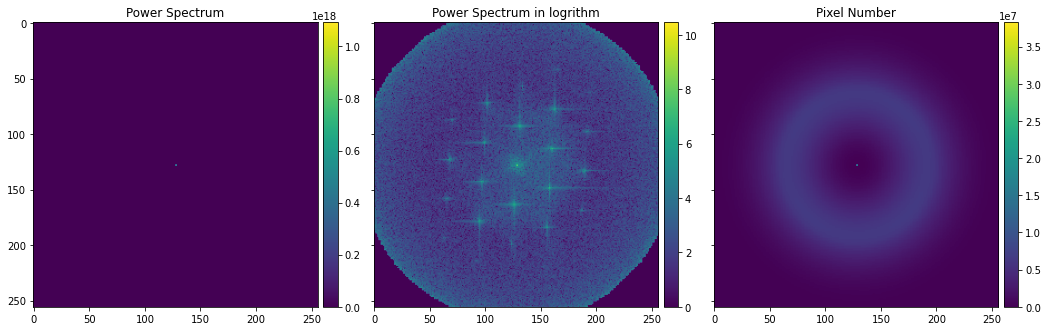

In [36]:
fig =plt.figure(1, figsize=(60, 20))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.square(np.abs(RTrotterSum*TrotterPixelNum)))
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Power Spectrum')
im=grid[1].imshow(np.log10(1+np.square(np.abs(RTrotterSum))))
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Power Spectrum in logrithm')
im=grid[2].imshow(np.square(TrotterPixelNum))
grid.cbar_axes[2].colorbar(im)
grid[2].set_title('Pixel Number')

Text(0.5, 1.0, 'Right Trotter amp')

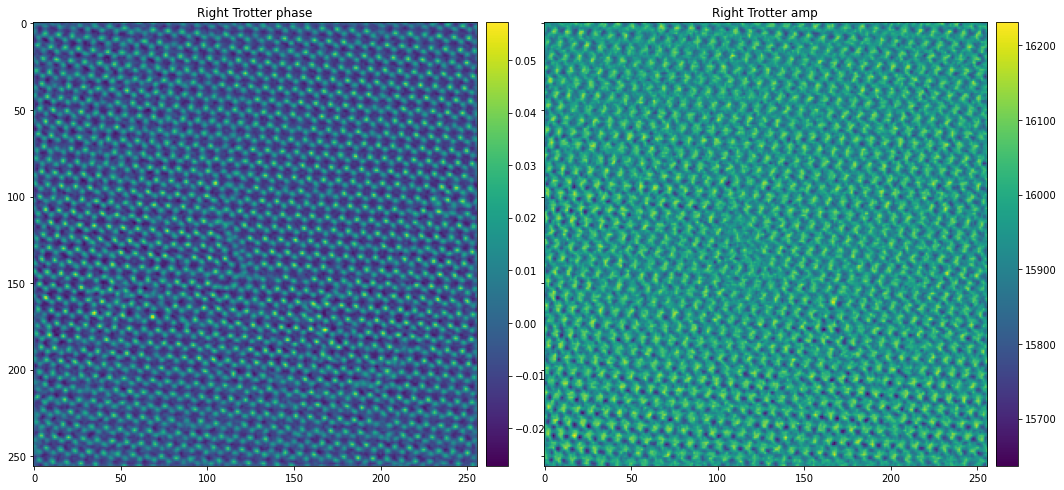

In [40]:
objectR =IFFT_2D(RTrotterSum*TrotterPixelNum)
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.angle(objectR))
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Right Trotter phase')
im=grid[1].imshow(np.abs(objectR))
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Right Trotter amp')

In [41]:
ratio = gama*dat4d.shape[0]/dat4d.shape[1]
#considering the affine transformation of the scanning positions. 
grid_Y, grid_X = np.indices(ADFImage.shape)
#compute the scanning vector.
step = 0.319
fast_shift = np.array([np.cos(theta_y-np.pi/2), np.sin(theta_y-np.pi/2)])*step
slow_shift = np.array([-np.sin(theta_x)/ratio, np.cos(theta_x)/ratio])*step
print(fast_shift)
print(slow_shift)
print(dat4d.shape)
#generate the scanning positions.
scan_X = np.cos(theta_y-np.pi/2)*grid_X - np.sin(theta_x)/ratio*grid_Y
scan_Y = np.sin(theta_y-np.pi/2)*grid_X + np.cos(theta_x)/ratio*grid_Y
max_range = np.max([np.max(scan_X) - np.min(scan_X),  np.max(scan_Y) - np.min(scan_Y)])
scaling = ADFImage.shape[1] / max_range
scan_X = scaling*(scan_X - np.min(scan_X) + (max_range - (np.max(scan_X) - np.min(scan_X)))/2)
scan_Y = scaling*(scan_Y - np.min(scan_Y) + (max_range - (np.max(scan_Y) - np.min(scan_Y)))/2)
deformed = griddata((scan_X.flatten(),scan_Y.flatten()), objectR.flatten(),(grid_X.flatten(),grid_Y.flatten()), method='cubic')
deformed = np.reshape(deformed, objectR.shape)
deformedADF = griddata((scan_X.flatten(),scan_Y.flatten()), ADFImage.flatten(),(grid_X.flatten(),grid_Y.flatten()), method='cubic')
deformedADF = np.reshape(deformedADF, ADFImage.shape)

[-0.00497187 -0.31896125]
[ 0.32184428 -0.00858223]
(256, 256, 128, 128)


Text(0.5, 1.0, 'Right Trotter phase')

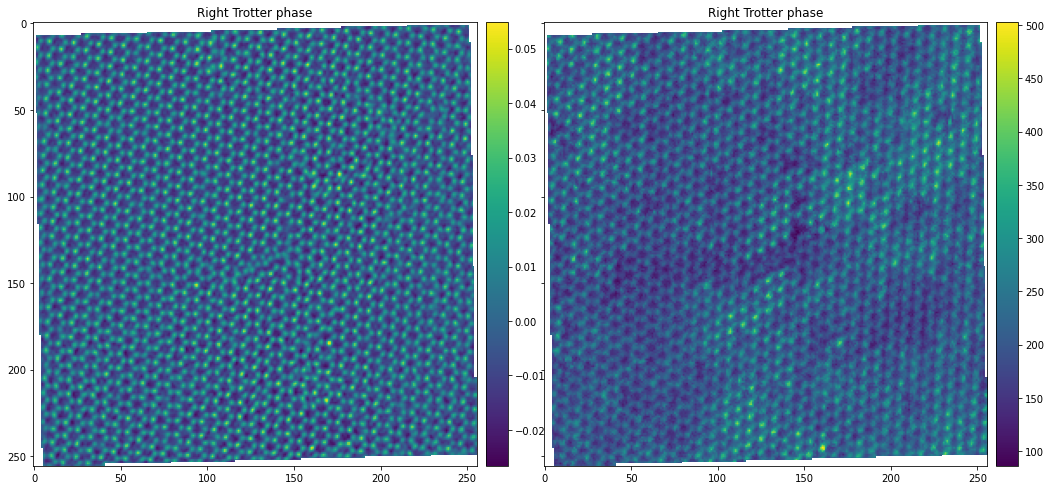

In [43]:
fig =plt.figure(1, figsize=(60, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.angle(deformed))
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Right Trotter phase')
im=grid[1].imshow(deformedADF)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Right Trotter phase')

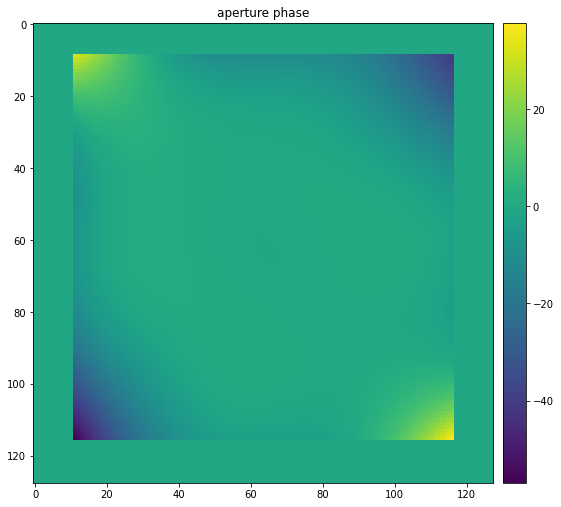

In [46]:
aper_phase = np.zeros_like(pacbed)
aper_phase[y_start:y_end,x_start:x_end] = probe_phase
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(aper_phase)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('aperture phase')
np.save(folder + "probe phase.npy", np.float32(aper_phase))